In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from sklearn import datasets
import sklearn
%matplotlib inline

torch.manual_seed(1)    # reproducible

In [2]:
def generate_data(N=80):
    r = np.linspace(0, 2,num=N)
    
    r1 = (2)*np.random.random_sample(N)
    r2 = (2)*np.random.random_sample(N)
    xTr1 = np.array([r1, np.power(r1,3)-2*np.square(r1)]).T
    xTr2 = np.array([r2, np.power(r2,3)-2*np.square(r2)-2.5+np.random.random_sample(N)]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

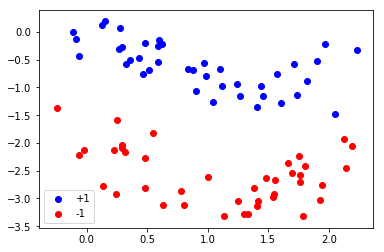

In [3]:
xTr,yTr,xTe,yTe=generate_data()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [4]:
def two_moons(N=10):
    x = sklearn.datasets.make_moons(n_samples=N, shuffle=False, noise=0.1, random_state=None)
    xTr = x[0]
    yTr = x[1]
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    return xTr,yTr,xTe,yTe

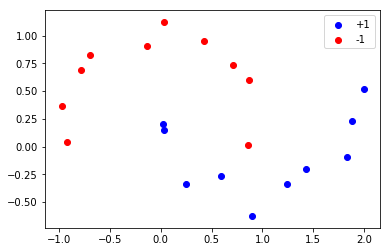

In [5]:
xTr,yTr,xTe,yTe=two_moons(40)
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

In [6]:
def validation_error(model,x,y):
    x = torch.from_numpy(x).float()
    y = torch.from_numpy(y)
    x = x.contiguous()
    x = x.view(-1,2)
    x, y = Variable(x), Variable(y)
    
    
    Z = (F.softmax(model(x)))
    Z = Z.log().data.numpy()
    y = np.eye(2)[y.data.numpy()]
    Z = -np.multiply(Z,y).sum(1)
    return Z.sum()/Z.shape[0]

In [7]:
import densenet as dn

In [8]:
dn_model = dn.DenseNet3(20, 2, 4, reduction=0.5,
                     bottleneck=True, dropRate=0)

In [9]:
dn_model

DenseNet3 (
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): DenseBlock (
    (layer): Sequential (
      (0): BottleneckBlock (
        (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (1): BottleneckBlock (
        (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True)
        (relu): ReLU (inplace)
        (conv1): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True)
        (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (2): BottleneckBlock (
        (bn1): BatchNorm2d(16, ep

In [10]:
# torch can only train on Variable, so convert them to Variable
x = torch.from_numpy(xTr).float()
y = torch.from_numpy(yTr)
x = x.contiguous()
x = x.view(-1,1,1,2)
x, y = Variable(x), Variable(y)

In [11]:
print('Number of model parameters: {}'.format(
            sum([p.data.nelement() for p in dn_model.parameters()])))

Number of model parameters: 30794


In [12]:
optimizer = torch.optim.SGD(dn_model.parameters(), lr=0.02)
loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted

In [13]:
def adjust_learning_rate(lr,epoch,optimizer,total_epoch):  
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr*(0.5** (epoch // (total_epoch/3)))*(0.5** (epoch // (total_epoch/2))) * (0.5 ** (epoch //(total_epoch*(3/4))))
    return optimizer.param_groups[0]['lr']

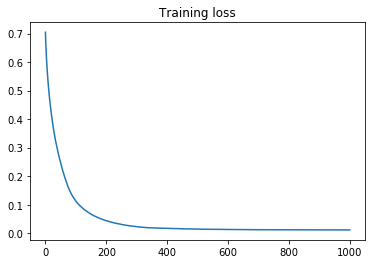

In [14]:
# plt.ion() 
loss_data = []
total_epoch = 1000
for epoch in range(total_epoch):
    lr = adjust_learning_rate(0.02,epoch,optimizer,total_epoch)
    out = dn_model(x)                 # input x and predict based on x
    loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
#     print(out)
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
#     print(epoch,lr)
    loss_data.append(loss.data[0])
#     print(optimizer.param_groups[0]['lr'])

plt.plot(range(total_epoch),loss_data)
plt.title('Training loss')

In [15]:
def train(model,total_epoch,xTr,yTr,xTe,yTe,lr=0.02,adjust=False):
    # torch can only train on Variable, so convert them to Variable
    x = torch.from_numpy(xTr).float()
    y = torch.from_numpy(yTr)
    x = x.contiguous()
    x = x.view(-1,2)
    x, y = Variable(x), Variable(y)

    xt = torch.from_numpy(xTe).float()
    yt = torch.from_numpy(yTe)
    xt = xt.view(-1,2)
    xt, yt = Variable(xt), Variable(yt)
    
    
    print('Number of model parameters: {}'.format(
            sum([p.data.nelement() for p in model.parameters()])))
    
    
    min_val = 0
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_func = torch.nn.CrossEntropyLoss()  # the target label is NOT an one-hotted
    
    loss_data = []
    validation_loss_data = []
    for epoch in range(total_epoch):

        if adjust:
            adjust_learning_rate(lr,epoch,optimizer,total_epoch)
        out = model(x)                 # input x and predict based on x
        loss = loss_func(out, y)     # must be (1. nn output, 2. target), the target label is NOT one-hotted
    #     print(out)
        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
#         print(lr)
        loss_data.append(loss.data[0])
        

        current_val = validation_error(model,xTe,yTe)
        
        
        if epoch == 1:
            min_val = validation_loss_data[0]
        validation_loss_data.append(current_val)
#         if epoch >2 and current_val >validation_loss_data[-2]:
#             break
        min_val = min(min_val,validation_loss_data[-1])

    
    print(loss_data[-1],validation_loss_data[-1])
    print('min validation error',min_val)
    figure = plt.figure(figsize=(20, 5))
    plt.subplot(1, 2 + 1, 1)
    plt.plot(loss_data)
    plt.title('Training loss vs Epoch')
    
    plt.subplot(1, 2 + 1, 2)
    plt.plot(validation_loss_data)
    plt.title('Validation loss vs Epoch')
    

In [16]:
class fc_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,n_hidden,dropRate):
        super(fc_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.n_hidden = n_hidden
        self.layer = self._make_layer(nb_layers, in_planes,n_hidden, dropRate,num_classes)
        self.out = nn.Linear(n_hidden,num_classes)
    
    def _make_layer(self,nb_layers,in_planes,n_hidden,dropRate,num_classes):
        layers = []
        for i in range(nb_layers):
            if i == 0:
                layers.append(nn.Linear(in_planes, n_hidden))
                layers.append(nn.ReLU(inplace=True))
            else:
                layers.append(nn.Linear(n_hidden, n_hidden))
                layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
#         x = F.relu(x)
        return self.out(x)

Number of model parameters: 530
0.010740680620074272 0.232769941288
min validation error 0.228092496734


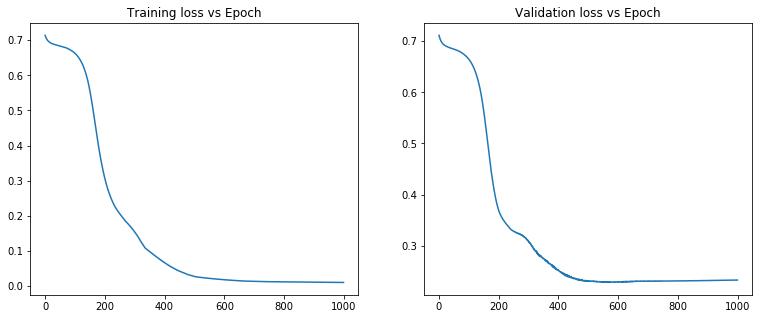

In [17]:
torch.manual_seed(1)
model_2 = fc_model(2,4,2,12,0.0)
train(model_2,1000,xTr,yTr,xTe,yTe,0.08,True)

In [18]:
class DenseLayer(nn.Module):
    def __init__(self,in_planes,n_hidden,dropRate):
        super(DenseLayer,self).__init__()
        self.Denselayer = nn.Linear(in_planes,n_hidden)
    
    def forward(self,x):
        out = self.Denselayer(x)
        out = F.relu(out)
        return torch.cat([x, out], 1)

class dense_model(torch.nn.Module):
    def __init__(self,num_classes,nb_layers,in_planes,dropRate,growth_rate):
        super(dense_model,self).__init__()
        self.dropRate = dropRate
        self.num_classes = num_classes
        self.in_planes = in_planes
        
        self.layer = self._make_layer(nb_layers,in_planes,dropRate,num_classes,growth_rate)
        self.out = nn.Linear(in_planes+nb_layers*growth_rate,num_classes)
    
    def _make_layer(self,nb_layers,in_planes,dropRate,num_classes,growth_rate):
        layers = []
        for i in range(nb_layers):
            layers.append(DenseLayer(in_planes+i*growth_rate, growth_rate,dropRate))
#             layers.append(nn.ReLU(inplace=True))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.layer(x)
        x = self.out(x)
        return (x)

Number of model parameters: 2634
0.028186026960611343 0.159740231533
min validation error 0.159740231533


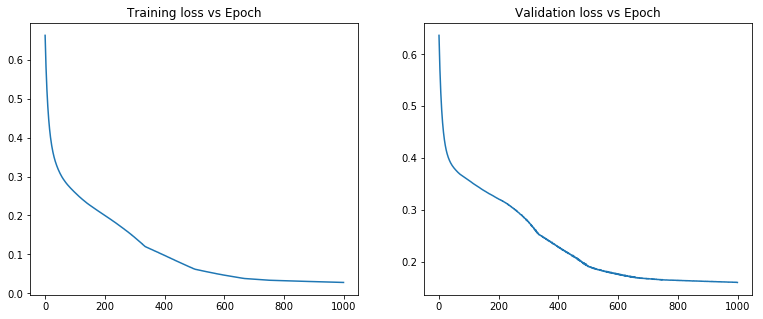

In [20]:
torch.manual_seed(1)
denseNet = dense_model(num_classes=2,nb_layers=8,in_planes= 2,dropRate = 0,growth_rate=9)

train(denseNet,1000,xTr,yTr,xTe,yTe,0.08,True)
  

In [1095]:
# torch.manual_seed(1)
# denseNet = dense_model(num_classes=2,nb_layers=8,in_planes= 2,dropRate = 0,growth_rate=8)

# train(denseNet,1000,xTr,yTr,xTe,yTe,0.1)

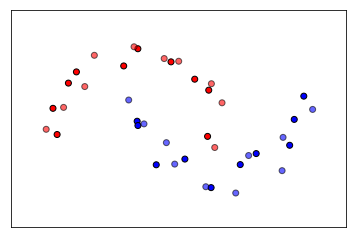

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

h = 0.02
x_min, x_max = xTr[:, 0].min() - .5, xTr[:, 0].max() + .5
y_min, y_max = xTr[:, 1].min() - .5, xTr[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax = plt.subplot(1, 1, 1)


# Plot the training points
ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
           edgecolors='k')
# and testing points
ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright, alpha=0.6,
           edgecolors='k')
ax.set_xlim(xx.min(), xx.max())
ax.set_ylim(yy.min(), yy.max())
ax.set_xticks(())
ax.set_yticks(())



grid = np.c_[xx.ravel(), yy.ravel()]
# torch can only train on Variable, so convert them to Variable
grid = torch.from_numpy(grid).float()
# x = x.contiguous()

grid = Variable(grid)

DenseNet Conv
(27462,)
1
Linear
(27462,)
2
Dense Model
(27462,)
3


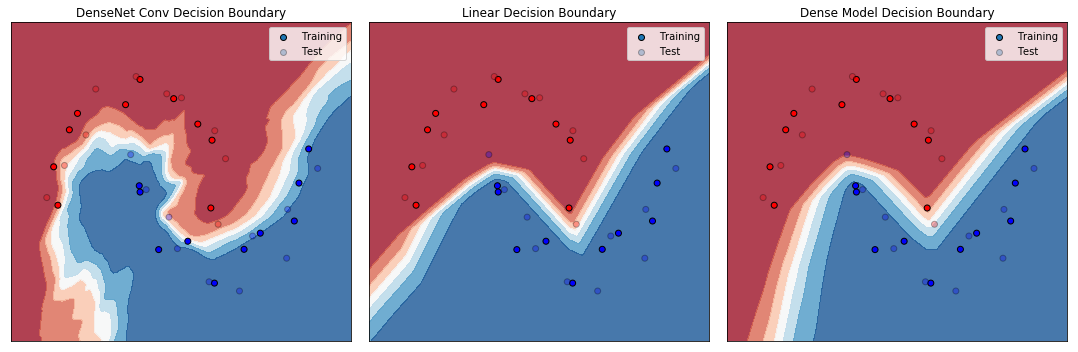

In [22]:
names = ["DenseNet Conv","Linear","Dense Model"]
models = [dn_model,model_2,denseNet]
i = 1

figure = plt.figure(figsize=(20, 5))
for name,model in zip(names,models):

    if name == "Linear" or name == "Dense Model":
        grid = grid.view(-1,2)
    else:
        grid = grid.view(-1,1,1,2)
         
    print(name)
    
    ax = plt.subplot(1, len(models) + 1, i)
#     print(model)
    Z = F.softmax(model(grid))
#     print(Z)
#     Z = Z[:,1].data.numpy()
    Z = Z.data.numpy().reshape(-1,2)[:,1]
    print(Z.shape)
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

    # Plot also the training points
    ax.scatter(xTr[:, 0], xTr[:, 1], c=yTr, cmap=cm_bright,
               edgecolors='k',label="Training")
    # and testing points
    ax.scatter(xTe[:, 0], xTe[:, 1], c=yTe, cmap=cm_bright,
               edgecolors='k', alpha=0.3,label="Test")

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    plt.title(name+" Decision Boundary")
    plt.tight_layout()
    plt.legend()
    print(i)
    i+=1
plt.show()

In [936]:
for name,item in denseNet.named_parameters():
    print(name)

layer.0.Denselayer.weight
layer.0.Denselayer.bias
layer.1.Denselayer.weight
layer.1.Denselayer.bias
layer.2.Denselayer.weight
layer.2.Denselayer.bias
layer.3.Denselayer.weight
layer.3.Denselayer.bias
layer.4.Denselayer.weight
layer.4.Denselayer.bias
layer.5.Denselayer.weight
layer.5.Denselayer.bias
out.weight
out.bias


In [937]:
denseNet.double()

dense_model (
  (layer): Sequential (
    (0): DenseLayer (
      (Denselayer): Linear (2 -> 2)
    )
    (1): DenseLayer (
      (Denselayer): Linear (4 -> 2)
    )
    (2): DenseLayer (
      (Denselayer): Linear (6 -> 2)
    )
    (3): DenseLayer (
      (Denselayer): Linear (8 -> 2)
    )
    (4): DenseLayer (
      (Denselayer): Linear (10 -> 2)
    )
    (5): DenseLayer (
      (Denselayer): Linear (12 -> 2)
    )
  )
  (out): Linear (14 -> 2)
)

In [1017]:
def plot_kernels(tensor, num_cols=6):
    if not tensor.ndim==4:
        raise Exception("assumes a 4D tensor")
    if not tensor.shape[-1]==3:
        raise Exception("last dim needs to be 3 to plot")
    num_kernels = tensor.shape[0]
    num_rows = 1+ num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols,num_rows))
    for i in range(tensor.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        ax1.imshow(tensor[i])
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
  
mm = denseNet.double()
filters = mm.modules
body_model = [i for i in mm.named_parameters()]

print(body_model[1])
layer1 = body_model[1]
tensor = layer1.data.numpy()
plot_kernels(tensor)

('layer.0.Denselayer.bias', Parameter containing:
-0.7263
-0.5623
[torch.DoubleTensor of size 2]
)


AttributeError: 'tuple' object has no attribute 'data'

In [1022]:
body_model

('layer.0.Denselayer.weight', Parameter containing:
 -0.1155  0.6824
  0.4742  0.5790
 [torch.DoubleTensor of size 2x2])

In [1019]:
grid

Variable containing:
-1.4773 -1.0486
-1.4573 -1.0486
-1.4373 -1.0486
       ⋮        
 2.5027  1.5714
 2.5227  1.5714
 2.5427  1.5714
[torch.FloatTensor of size 26664x2]

In [1027]:
body_model[0]*grid[0]

Variable containing:
-1.4773
-1.0486
[torch.FloatTensor of size 2]

In [1035]:
torch.matmul(body_model[0][1],grid[0])

TypeError: torch.addmv received an invalid combination of arguments - got (int, torch.DoubleTensor, int, torch.DoubleTensor, torch.FloatTensor, out=torch.DoubleTensor), but expected one of:
 * (torch.DoubleTensor source, torch.DoubleTensor mat, torch.DoubleTensor vec, *, torch.DoubleTensor out)
 * (float beta, torch.DoubleTensor source, torch.DoubleTensor mat, torch.DoubleTensor vec, *, torch.DoubleTensor out)
 * (torch.DoubleTensor source, float alpha, torch.DoubleTensor mat, torch.DoubleTensor vec, *, torch.DoubleTensor out)
 * (float beta, torch.DoubleTensor source, float alpha, torch.DoubleTensor mat, torch.DoubleTensor vec, *, torch.DoubleTensor out)
      didn't match because some of the arguments have invalid types: ([32;1mint[0m, [32;1mtorch.DoubleTensor[0m, [32;1mint[0m, [32;1mtorch.DoubleTensor[0m, [31;1mtorch.FloatTensor[0m, [32;1mout=torch.DoubleTensor[0m)


In [1040]:
(body_model[0][1] * grid[0].double()).+body_model[1][1]

Variable containing:
-0.5556 -1.2779
-1.4267 -1.1695
[torch.DoubleTensor of size 2x2]

In [1058]:
body_model[0][1].mm(grid[0].view(2,1).double())+body_model[1][1].view(2,1)

Variable containing:
-1.2712
-1.8700
[torch.DoubleTensor of size 2x1]

In [1051]:
torch.mul(body_model[0][1],grid[0].view(2,1).double())+body_model[1][1].view(2,1)

Variable containing:
 0.1706 -1.0081
-0.4972 -0.6072
[torch.DoubleTensor of size 2x2]

In [1044]:
body_model[1][1]

Parameter containing:
-0.7263
-0.5623
[torch.DoubleTensor of size 2]

In [1048]:
grid[0].view(2,1)

Variable containing:
-1.4773
-1.0486
[torch.FloatTensor of size 2x1]

In [1057]:
body_model[1][1].view(2,1)

Variable containing:
-0.7263
-0.5623
[torch.DoubleTensor of size 2x1]